In [1]:
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as f
import torch.utils.data as data
import torch.optim as optim
import numpy as np
from datasets import load_dataset

In [2]:
mnist = load_dataset("mnist")
train, test = mnist.get("train"), mnist.get("test")

In [3]:
train.set_format(type="numpy", columns=["image", "label"])
test.set_format(type="numpy", columns=["image", "label"])
num_train_samples = 10000
num_test_samples = 1000

train_indices = np.random.choice(num_train_samples, num_train_samples, replace=False)
test_indices = np.random.choice(num_test_samples, num_test_samples, replace=False)
train = train.rename_column("image", "input").select(train_indices)
test = test.rename_column("image", "input").select(test_indices)

In [4]:
def preprocess(example):
    arr = np.reshape(example["input"], -1)
    example["input"] = arr
    return example

train = train.map(preprocess, num_proc=2)
test = test.map(preprocess, num_proc=2)

Map (num_proc=2):   0%|          | 0/10000 [00:00<?, ? examples/s]

/home/ubuntu/.local/lib/python3.10/site-packages/datasets/features/image.py:348: UserWarning: Downcasting array dtype int64 to int32 to be compatible with 'Pillow'
  warnings.warn(f"Downcasting array dtype {dtype} to {dest_dtype} to be compatible with 'Pillow'")
/home/ubuntu/.local/lib/python3.10/site-packages/datasets/features/image.py:348: UserWarning: Downcasting array dtype int64 to int32 to be compatible with 'Pillow'
  warnings.warn(f"Downcasting array dtype {dtype} to {dest_dtype} to be compatible with 'Pillow'")


Map (num_proc=2):   0%|          | 0/1000 [00:00<?, ? examples/s]

/home/ubuntu/.local/lib/python3.10/site-packages/datasets/features/image.py:348: UserWarning: Downcasting array dtype int64 to int32 to be compatible with 'Pillow'
  warnings.warn(f"Downcasting array dtype {dtype} to {dest_dtype} to be compatible with 'Pillow'")
/home/ubuntu/.local/lib/python3.10/site-packages/datasets/features/image.py:348: UserWarning: Downcasting array dtype int64 to int32 to be compatible with 'Pillow'
  warnings.warn(f"Downcasting array dtype {dtype} to {dest_dtype} to be compatible with 'Pillow'")


In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
train_inputs = torch.from_numpy(train["input"]).float().squeeze()
test_inputs = torch.from_numpy(test["input"]).float().squeeze()
train_labels = torch.from_numpy(train["label"]).long()
test_labels = torch.from_numpy(test["label"]).long()


In [6]:
train_dataset = data.TensorDataset(train_inputs, train_labels)
test_dataset = data.TensorDataset(test_inputs, test_labels)

In [7]:
class Model(nn.Module):

    def __init__(self):
        super().__init__()
        self.linear_1 = nn.Linear(28 * 28, 512)
        self.norm_1 = nn.LayerNorm(512)
        self.drop_1 = nn.Dropout(p=0.4)
        self.linear_2 = nn.Linear(512, 512)
        self.norm_2 = nn.LayerNorm(512)
        self.drop_2 = nn.Dropout(p=0.2)
        self.linear_3 = nn.Linear(512, 512)
        self.norm_3 = nn.LayerNorm(512)
        self.linear_4 = nn.Linear(512, 10)
        

    def forward(self, x):
        x = self.drop_1(f.relu(self.norm_1(self.linear_1(x))))
        x = self.drop_2(f.relu(self.norm_2(self.linear_2(x))))
        x = f.relu(self.norm_3(self.linear_3(x)))
        out = self.linear_4(x)
        return out


In [8]:
def create_dataloader(dataset, batch_size):
    return data.DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=False, num_workers=2, pin_memory=True)

def test(model, dataloader,  device=None, verbose=False):
    if verbose:
        print("Testing has started")
    
    model.eval()
    model = model.to(device)
    loss_fn = nn.CrossEntropyLoss()
    test_loss = 0

    with torch.no_grad():

            
        test_loss /= len(dataloader)
        
    if verbose:
        print(f"Testing complete, loss: {test_loss:.3f}")
        
    return test_loss

def train(model, optimizer, train_dataloader, test_dataloader, epochs=10, device=None, verbose=False):
    if verbose:
        print("Training has started")
        
    model = model.to(device)
    loss_fn = nn.CrossEntropyLoss()
    train_losses = []
    test_losses = []
    test_accuracies = []
    
    for epoch in range(epochs):
        train_loss = 0
        model.train()
        
        for inputs, labels in train_dataloader:
            inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
    
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        test_loss = 0
        accuracy = 0
        num_samples = 0
        model.eval()
        with torch.no_grad():
            for inputs, labels in test_dataloader:
                inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
                
                outputs = model(inputs)
                loss = loss_fn(outputs, labels)
                test_loss += loss.item()
                correct = torch.sum(torch.argmax(outputs, dim=-1) == labels)
                accuracy += correct.item()
                num_samples += len(labels)

        train_loss /= len(train_dataloader)
        test_loss /= len(test_dataloader)
        accuracy /= num_samples
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        test_accuracies.append(accuracy)
        if verbose and epoch and ((epoch + 1) % int(epochs * 0.25) == 0):
            print(f"Epoch {epoch + 1} complete, train loss: {train_loss:.3f}, test loss: {test_loss:.3f}, accuracy: {accuracy * 100:.2f}")

    if verbose:
        print("Training is complete")

    return train_losses, test_losses, test_accuracies

In [22]:
def plot_loss_and_accuracy(train_loss, test_loss, test_accuracy, path):
    epochs = range(1, len(train_loss) + 1)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    ax1.plot(epochs, train_loss, label="Training Loss", color="dodgerblue")
    ax1.plot(epochs, test_loss, label="Testing Loss", color="red")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper left")
    ax1.set_title("Loss vs. Epoch")

    ax2.plot(epochs, test_accuracy, label="Testing Accuracy", color="blueviolet")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Accuracy")
    ax2.legend(loc="upper left")
    ax2.set_title("Accuracy vs. Epoch")

    plt.style.use("dark_background")
    plt.savefig(path, dpi=300)
    plt.show()

## Batch Gradient Descent

In [23]:
train_dataloader = create_dataloader(train_dataset, batch_size=len(train_dataset))
test_dataloader = create_dataloader(test_dataset, batch_size=len(test_dataset))

model = Model()
optimizer = optim.SGD(model.parameters(), lr=1e-1, momentum=0)

In [24]:
print(f"Parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

Parameters: 935434


In [25]:
train_loss, test_loss, test_acc = train(model, optimizer, train_dataloader, test_dataloader, epochs=100, device=device, verbose=True)

Training has started
Epoch 25 complete, train loss: 0.640, test loss: 0.747, accuracy: 73.50
Epoch 50 complete, train loss: 0.325, test loss: 0.331, accuracy: 88.90
Epoch 75 complete, train loss: 0.256, test loss: 0.284, accuracy: 91.30
Epoch 100 complete, train loss: 0.209, test loss: 0.249, accuracy: 92.20
Training is complete


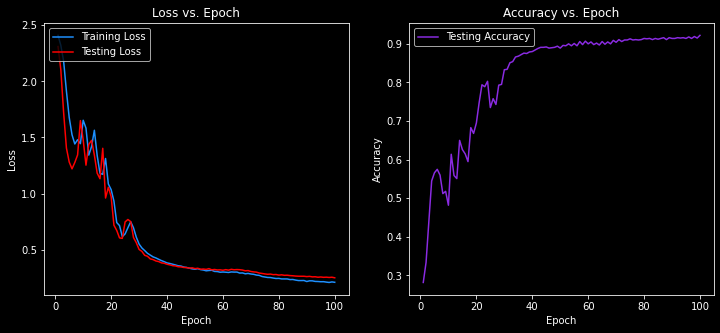

In [26]:
plot_loss_and_accuracy(train_loss, test_loss, test_acc, "./batch_metrics.png")

## Mini-Batch Gradient Descent

In [27]:
train_dataloader = create_dataloader(train_dataset, batch_size=64)
test_dataloader = create_dataloader(test_dataset, batch_size=len(test_dataset))

model = Model()
optimizer = optim.SGD(model.parameters(), lr=1e-1, momentum=0)

In [28]:
train_loss, test_loss, test_acc = train(model, optimizer, train_dataloader, test_dataloader, epochs=100, device=device, verbose=True)

Training has started
Epoch 25 complete, train loss: 0.021, test loss: 0.166, accuracy: 95.30
Epoch 50 complete, train loss: 0.011, test loss: 0.210, accuracy: 95.90
Epoch 75 complete, train loss: 0.010, test loss: 0.203, accuracy: 95.90
Epoch 100 complete, train loss: 0.007, test loss: 0.174, accuracy: 96.70
Training is complete


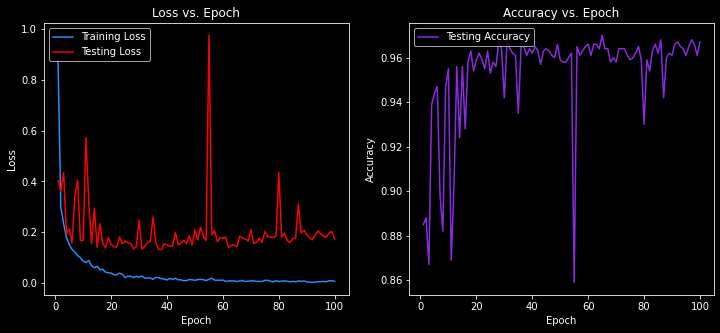

In [29]:
plot_loss_and_accuracy(train_loss, test_loss, test_acc, "./mini_batch_metrics.png")

## Stochastic Gradient Descent

In [34]:
train_dataloader = create_dataloader(train_dataset, batch_size=1)
test_dataloader = create_dataloader(test_dataset, batch_size=len(test_dataset))

model = Model()
optimizer = optim.SGD(model.parameters(), lr=1e-1, momentum=0)

In [35]:
train_loss, test_loss, test_acc = train(model, optimizer, train_dataloader, test_dataloader, epochs=100, device=device, verbose=True)

Training has started
Epoch 25 complete, train loss: 0.061, test loss: 0.189, accuracy: 95.20
Epoch 50 complete, train loss: 0.025, test loss: 0.217, accuracy: 95.90
Epoch 75 complete, train loss: 0.017, test loss: 0.226, accuracy: 96.50
Epoch 100 complete, train loss: 0.013, test loss: 0.310, accuracy: 95.30
Training is complete


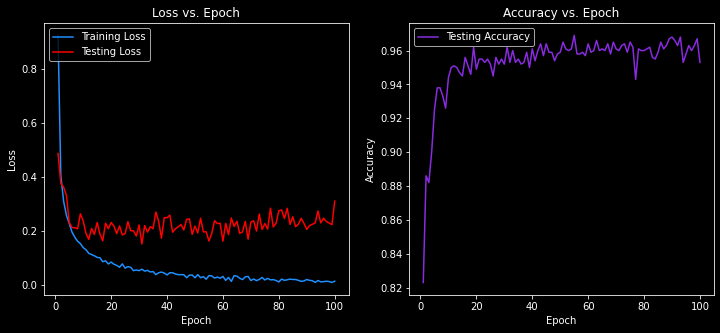

In [36]:
plot_loss_and_accuracy(train_loss, test_loss, test_acc, "./stochastic_metrics.png")